In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cmath
import math
from scipy.optimize import fmin, minimize
from astropy import units as u
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import copy
%matplotlib inline

from PIL import Image

In [9]:
class data:
    u: float
    v: float
    phase: float
    amp: float
    sigma: float
    vis_data: complex
    def __init__(self, u, v, phase, amp, sigma):
        self.u = u
        self.v = v
        self.phase = phase
        self.amp = amp
        self.sigma = sigma
        self.vis_data = amp * np.exp(1j * math.radians(phase))

    def __repr__(self):
        return f"[u: {self.u}, v: {self.v}]"

    def __str__(self):
        return f"[u: {self.u}, v: {self.v}]"

image_shift_half_shift_half_shift_half_shift_half_shift_half_shift_half_shift_half_shift_half_shift_half_shift_half_shift_half is a 2d numpy array
image is 2d of numbers (greyscale image)

In [10]:
# Assumption image is 80px by 80px => 6400 variables
def loss(image, data_list: list[data], coords, p = 2, reg_weight = 1, FOV = 100*u.uas.to(u.rad)): #Ask about u.rad
    error_sum = 0
    vis_images = interpolate(image, coords, FOV)

    for i in range(len(data_list)):
        vis_data = data_list[i].amp * np.exp(1j * math.radians(data_list[i].phase))
        vis_image = vis_images[i]
        error = (abs(vis_image-vis_data) / data_list[i].sigma) ** 2
        error_sum += error
    
    return error_sum + reg_weight * calc_regularizer(image=image, tsv=True, p=2)

In [11]:
# Assumption image_shift_half is 80x80 pixels
# Pass in array of u,v coords then return array of interpolated values
def interpolate(image_shift_half, coords, FOV):
    ft_image = np.fft.fftshift(np.fft.fft2(image_shift_half)) # Investigate to make sure what this fft does

    #kx_1 = 2*math.pi/FOV
    kx_1 = 1/FOV
    # kx_1 is 1/coeff

    kx = np.linspace(ft_image.shape[0]//-2, (ft_image.shape[0])//2 - 1, ft_image.shape[0]) * kx_1
    ky = np.linspace(ft_image.shape[0]//-2, (ft_image.shape[1])//2 - 1, ft_image.shape[1]) * kx_1
    
    interp_real = RegularGridInterpolator((kx, ky), ft_image.real, bounds_error=False, method="linear")
    interp_imag = RegularGridInterpolator((kx, ky), ft_image.imag, bounds_error=False, method="linear")

    real = interp_real(coords)
    imag = interp_imag(coords)
    #print(imag)
    return real + imag * 1j

In [12]:
# p is the exponent of the regularizing terms
# The smaller p the more sensitive it is to noise
# TSV = Total Squared Variation
def calc_regularizer(image: np.array, tsv=False, p=None):
    if tsv and p == None:
        raise Exception("p value not set")
    reg = 0
    if tsv:
        image_lshift = np.copy(image, subok=True)
        image_lshift = np.roll(image_lshift, -1,axis=1)
        image_lshift[:,-1] = 0
        image_upshift = np.copy(image, subok=True)
        image_upshift = np.roll(image_upshift, -1, axis=0)
        image_upshift[-1] = 0

        term_1 = np.power(np.absolute(np.subtract(image_lshift, image)),p)
        term_2 = np.power(np.absolute(np.subtract(image_upshift, image)),p)
        reg = np.sum(np.add(term_1,term_2))
    return reg

In [13]:
img = np.squeeze(tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img('images/3597_blur_avg.png', color_mode='grayscale')), axis=-1)

Make sure that the ring is right size and position

In [14]:
def process_data(data_df):
    coords = []
    data_list = []
    for i in range(len(data_df)):
        data_list.append(data(data_df.loc[i, 'U(lambda)'], data_df.loc[i, 'V(lambda)'], data_df.loc[i, 'Iphase(d)'], data_df.loc[i, 'Iamp(Jy)'], data_df.loc[i, 'Isigma(Jy)']))
        coords.append([data_df.loc[i, 'U(lambda)'], data_df.loc[i, 'V(lambda)']])
    coords = np.array(coords)
    return coords, data_list

In [15]:
def read_data(filename: str()):
    df = pd.read_csv(filename)
    return df

In [16]:
df = read_data("./data/SR1_M87_2017_095_hi_hops_netcal_StokesI.csv")
coords, data_list = process_data(df)
len(data_list)

6458

In [17]:
file = open("images/3597_blur_avg.txt","r")
lines = file.readlines()

In [18]:
image_shift_half = np.empty([180,180])
image = np.empty([180,180])

In [19]:
t = []
for line in lines:
    coord = line.strip().split()
    x = int(float(coord[0]) * 1000000)
    y = int(float(coord[1]) * 1000000)
    z = int(float(coord[2]) * 10000000000)
    image_shift_half[x][y] = z
    image[x+90][y+90] = z

(-0.5, 179.5, 179.5, -0.5)

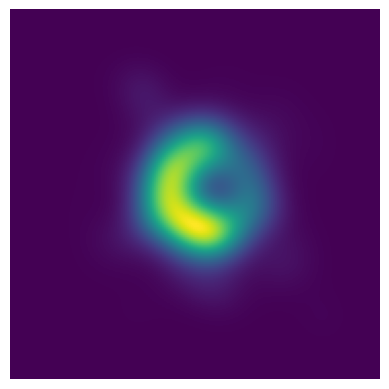

In [20]:
plt.figure()
plt.imshow(image)
plt.axis('off')

(-0.5, 179.5, 179.5, -0.5)

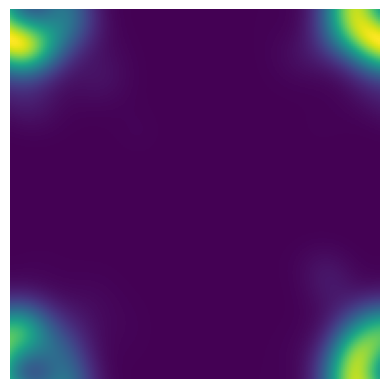

In [21]:
plt.figure()
plt.imshow(image_shift_half)
plt.axis('off')

Plot Loss function of image_copy - t * grad as a function of t in the gradient descent code
    Use t \in [-something to something]

Plot FF of image over onto the data

Document and Notebook

In [22]:
ft_image = np.fft.fftshift(np.fft.fft2(image))

(-0.5, 179.5, 179.5, -0.5)

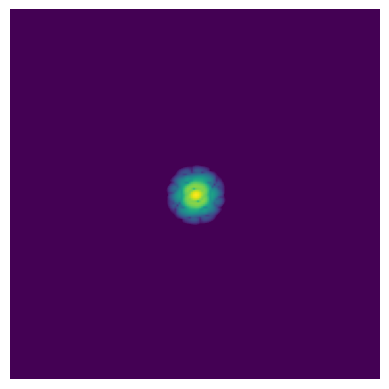

In [23]:
plt.figure()
plt.imshow(np.log(np.abs(ft_image)), vmin=10)
plt.axis('off')

X = U/Kx + 90
Y = U/Kx + 90

In [24]:
FOV=180*u.uas.to(u.rad)
kx_1 = 1/FOV

In [25]:
x,y = [], []
for data in data_list:
    x.append((data.u/kx_1+90))
    y.append(data.v/kx_1+90)

(-0.5, 179.5, 179.5, -0.5)

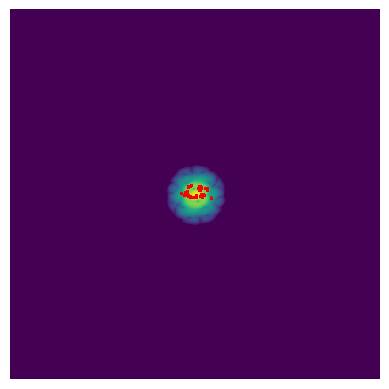

In [26]:
plt.figure()
plt.imshow(np.log(np.abs(ft_image)), vmin=10)
plt.scatter(x,y,color="red",s=0.1)
plt.axis('off')

(82.09413015741285, 97.9058408003084, 84.91551277675727, 91.50982392796048)

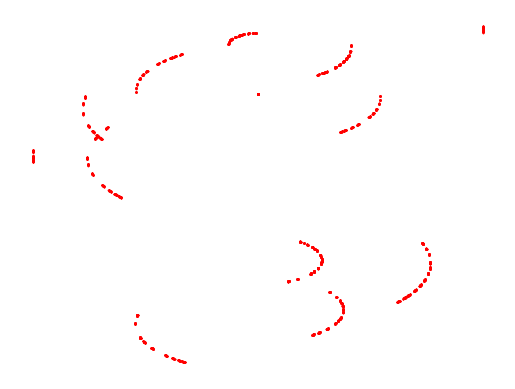

In [27]:
plt.figure()
plt.scatter(x,y,color="red",s=0.1)
plt.axis('off')

In [28]:
def gradient(data_list: list[data], coords, image, mode = 1): # 0 For central, -1 for backward, 1 for forward
    image_copy = np.copy(image, subok=True)
    upper_diff: float
    lower_diff: float
    h: float
    gradient_arr = np.empty(np.shape(image),dtype=np.complex_)
    if (mode == 0): # Central difference
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] += 1e-6 / 2
                upper_diff = loss(image_copy, data_list, coords)
                image_copy[row,col] -= 1e-6
                lower_diff = loss(image_copy, data_list, coords)
                image_copy[row,col] = image[row,col] # Reset that pixel to original value
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-6
    elif (mode == -1): # Backward difference
        upper_diff = loss(image, data_list, coords)
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] -= 1e-8 # Check with Misha 
                lower_diff = loss(image_copy, data_list, coords)
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-8
                image_copy[row,col] = image[row,col]
    elif (mode == 1) : # Forward difference is default
        lower_diff = loss(image, data_list, coords)
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] += 1e-8 # Check with Misha 
                upper_diff = loss(image_copy, data_list, coords)
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-8
                image_copy[row,col] = image[row,col]
    else:
        raise ValueError('Incorrect mode for finite differences')
    return gradient_arr
    #Return a Gradient 2d array?

(-1.0999999999999999e-07,
 1.0999999999999999e-07,
 -13325724378738.113,
 279840590652824.8)

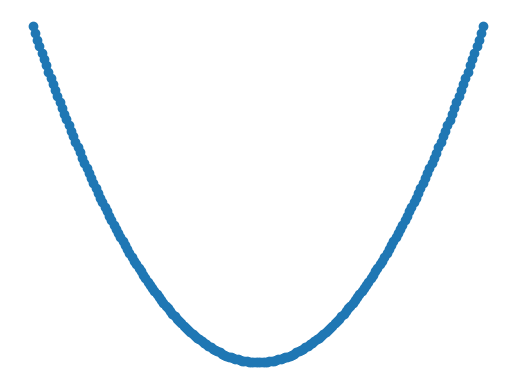

In [29]:
image = np.zeros([80,80])
t = np.array(range(-100,101))/1000000000

grad = gradient(data_list, coords, image)
losses = []
for i in t:
    new_image = image - i * grad
    losses.append(loss(new_image, data_list, coords))

plt.figure()
plt.scatter(t,losses)
plt.axis('off')

In [30]:
t = np.array(range(-100,101))/1000000000
losses = []
for i in t:
    new_image = image - i * grad
    losses.append(loss(new_image, data_list, coords))

(-1.0999999999999999e-07,
 1.0999999999999999e-07,
 -13325724378738.113,
 279840590652824.8)

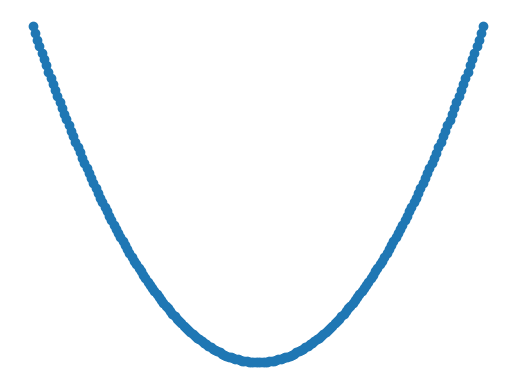

In [31]:
plt.figure()
plt.scatter(t,losses)
plt.axis('off')

In [32]:
losses.index(min(losses))-100

0